In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import struct as st
import gzip
import sklearn.linear_model as lm

In [2]:
'''
HELPER FUNCTIONS AND CONSTANTS
'''
    
# Number of digits being examined 
num_digits = 10 

# Given a path to image data in .gz format, extracts and returns the image data 
# as a 3-dimensional numpy array, where axis 0 corresponds with images, and 
# axes 1 and 2 correspond with the x and y axes of the images
def get_image_data(path): 
    f = gzip.open(path, 'rb')
    magic, dat_size, rows, cols = st.unpack('>IIII', f.read(16))
    num_bytes = dat_size * rows * cols
    data = st.unpack('>' + 'B' * num_bytes, f.read(num_bytes))
    data = np.asarray(data).reshape(dat_size, rows, cols)
    f.close()
    return data

# Given a path to label data in .gz format, extracts and returns the label data 
# as a 1-dimensional numpy array, where the ith entry indicates the correct 
# digit associated with the ith image
def get_label_data(path):
    f = gzip.open(path, 'rb')
    magic, dat_size = st.unpack('>II', f.read(8))
    data = st.unpack('>' + 'B' * dat_size, f.read(dat_size))
    data = np.asarray(data)
    f.close()
    return data

# Given a 1-dimensional numpy array of labels, constructs and returns a version 
# of the label data where each label is converted to a length num_digits array 
# of 0s and one 1, where the position of the 1 indicates which digit the label 
# is associated with (index 0 = digit 1, index 1 = digit 2, ..., index 9 = digit 0)
def construct_y(labels):
    n = len(labels)
    Y = np.zeros((num_digits, n))
    for i, label in enumerate(labels):
        Y[int(label) - 1, i] = 1
    return Y

# Given an array of computed labels, where the entries of the labels need not 
# be 0s or 1s, converts the computed labels to the most well-approximated labels
# where the entries are only 0s or 1s and returns the estimated labels 
# - If Y is 1-dimensional, converts values greater than or equal to 0.5 to 1, 
#   and converts values less than 0.5 to 0 
# - If Y is 2-dimensional, then for each label, converts all values other than 
#   the largest value to 0, and converts the largest value to 1 
def estimate_labels(Y):
    if (len(Y.shape) == 1): # Y is 1-D
        Y_est = np.zeros(len(Y))
        for i in range(len(Y)):
            if (Y[i] >= 0.5):
                Y_est[i] = 1
    else: # Y is 2-D 
        Y_est = np.zeros((Y.shape[0], Y.shape[1]))
        for i in range(Y.shape[1]):
            max_index = np.argmax(Y[:, i])
            Y_est[max_index, i] = 1
    return Y_est 

# Given a mapping from image space to label space A and the desired figure name, 
# visualizes each row of the model in 2-dimensional pixel space.
def plot_A(A, model_name):
    plt.figure(figsize=(13, 5), dpi=100)
    plt.suptitle(model_name, fontsize=15)
    for i in range(num_digits):
        plt.subplot(2, 5, i + 1)
        plt.title('Model Row {}'.format(i + 1))
        vmax = np.max(np.absolute(A[i, :]))
        plt.imshow(A[i, :].reshape(rows, cols), cmap='bwr', vmin=-vmax, vmax=vmax)
        plt.colorbar()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [3]:
'''
LOAD THE MNIST DATA (both the training and the testing data)
'''

# Load training data 
train_images = get_image_data('data/train_images.gz')
train_labels = get_label_data('data/train_labels.gz')

# Load test data 
test_images = get_image_data('data/test_images.gz')
test_labels = get_label_data('data/test_labels.gz')

# Get data dimensions
num_train = train_images.shape[0]
num_test = test_images.shape[0]
rows = train_images.shape[1]
cols = train_images.shape[2]
N = rows * cols

# Get training inputs and outputs 
X_train = train_images.reshape(num_train, N).T
Y_train = construct_y(train_labels)

# Get test inputs and outputs 
X_test = test_images.reshape(num_test, N).T
Y_test = construct_y(test_labels)

# Note: The columns of X_train and X_test correspond with images 
#       The columns of Y_train and Y_test correspond with labels

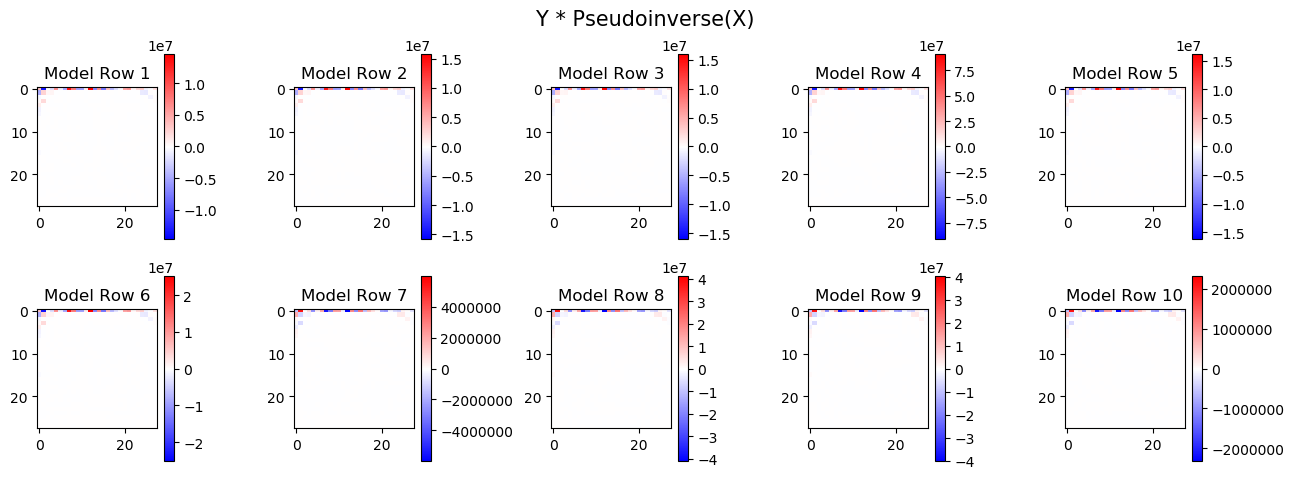

In [4]:
'''
1) Using various AX = B solvers, determine a mapping from the image space 
   to the label space.
'''
# Method 1: Pseudo inverse
A = Y_train @ linalg.pinv(X_train)
plot_A(A, 'Y * Pseudoinverse(X)')

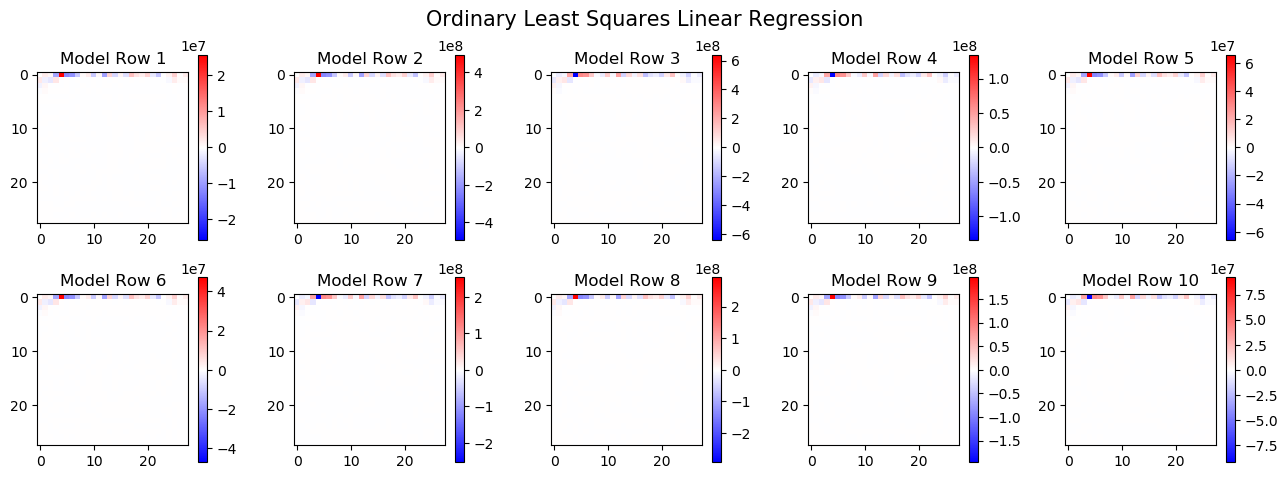

In [5]:
# Method 2: Ordinary least squares linear regression 
A = lm.LinearRegression().fit(X_train.T, Y_train.T).coef_
plot_A(A, 'Ordinary Least Squares Linear Regression')

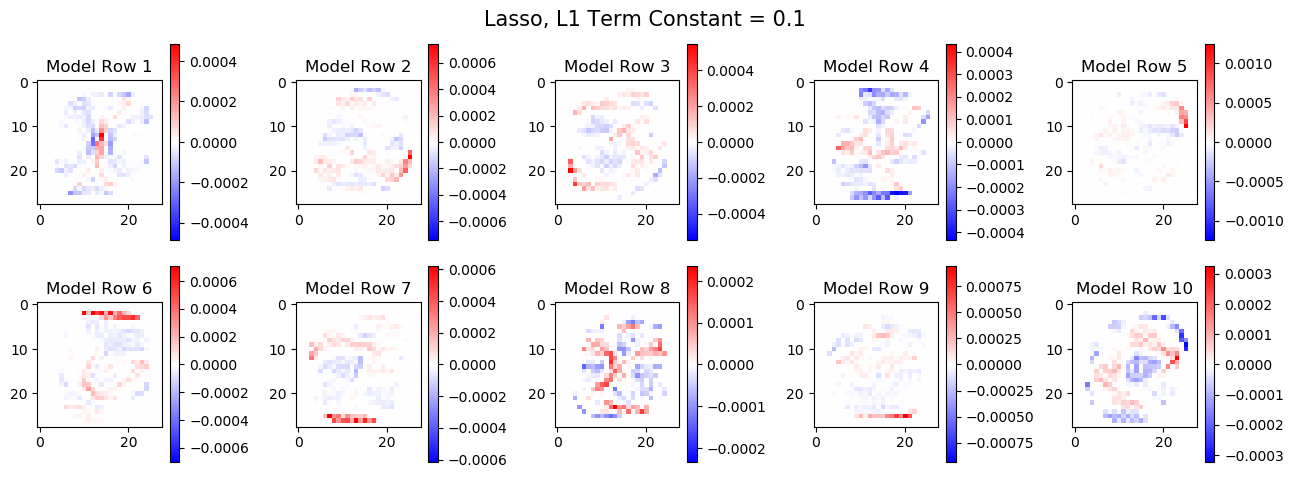

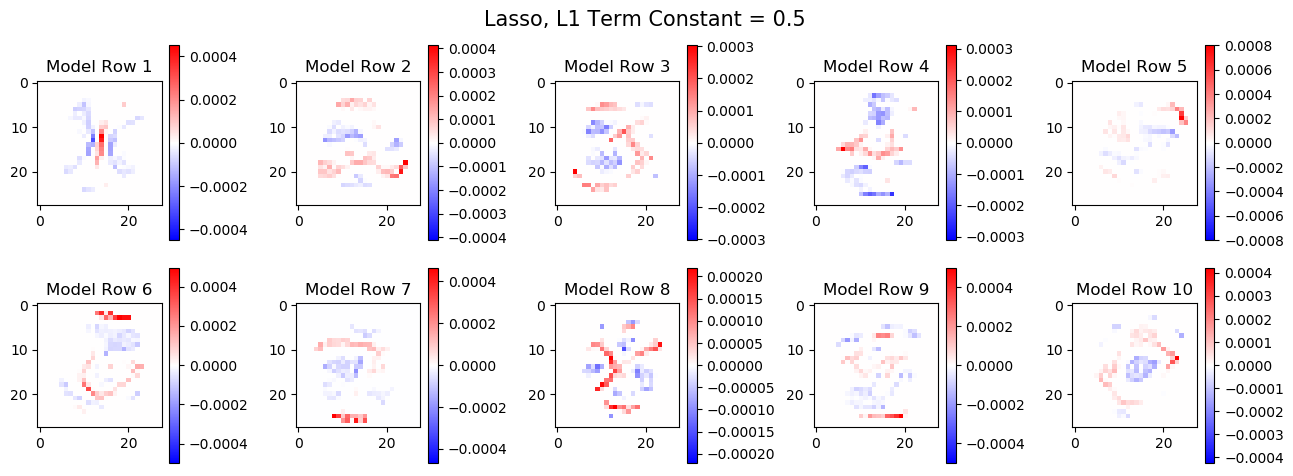

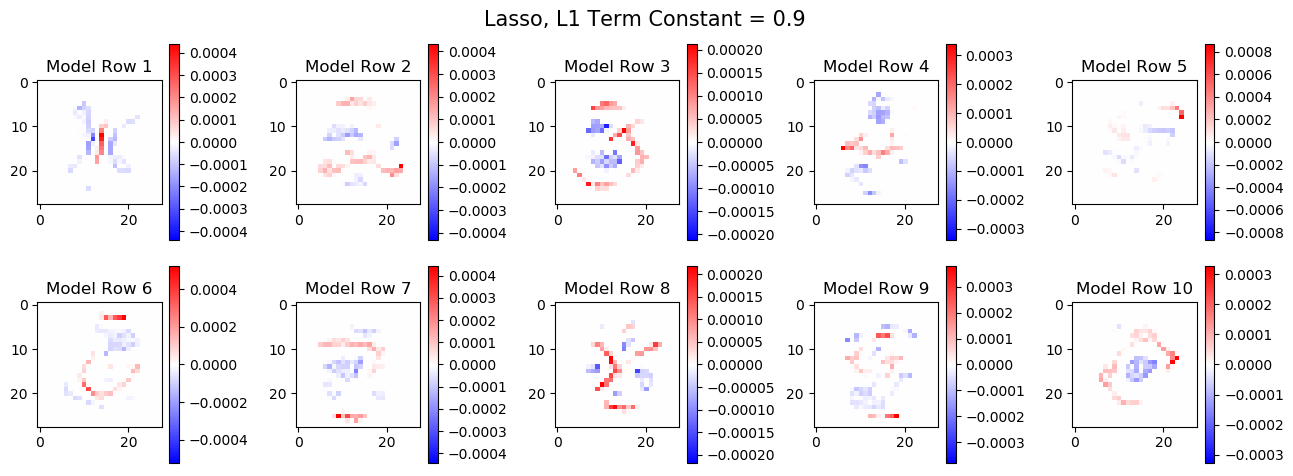

In [6]:
# Method 3: Lasso (linear model trained with L1 prior as regularizer)
alpha_vals = [0.1, 0.5, 0.9]
for alpha in alpha_vals:
    A = lm.Lasso(alpha=alpha).fit(X_train.T, Y_train.T).coef_
    plot_A(A, 'Lasso, L1 Term Constant = {}'.format(alpha))

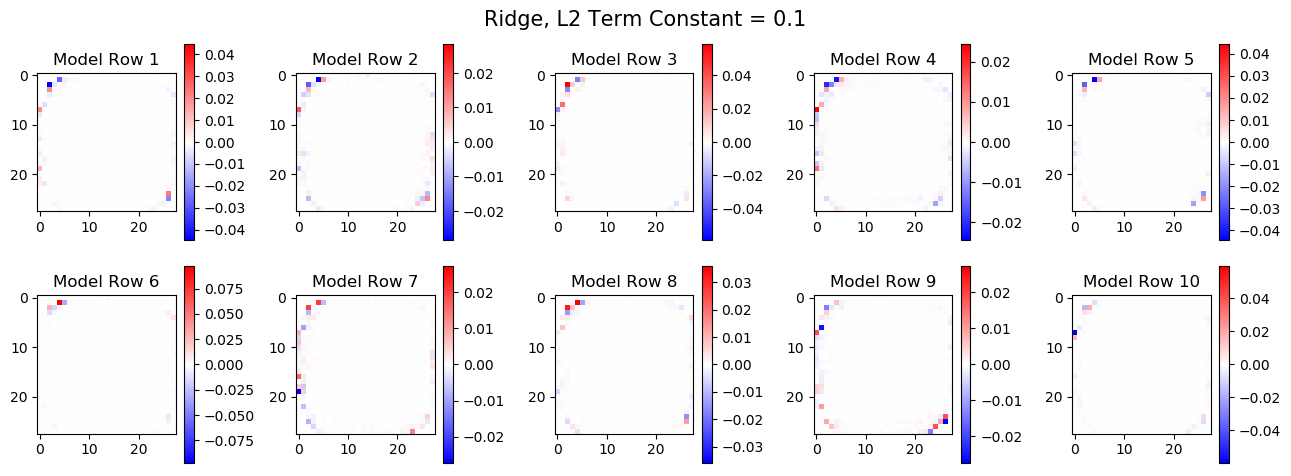

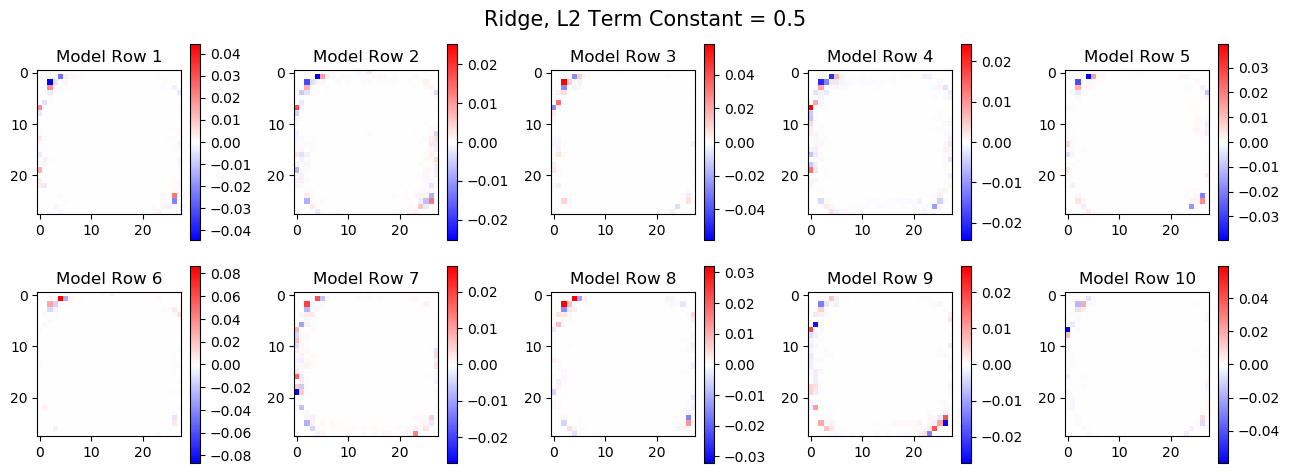

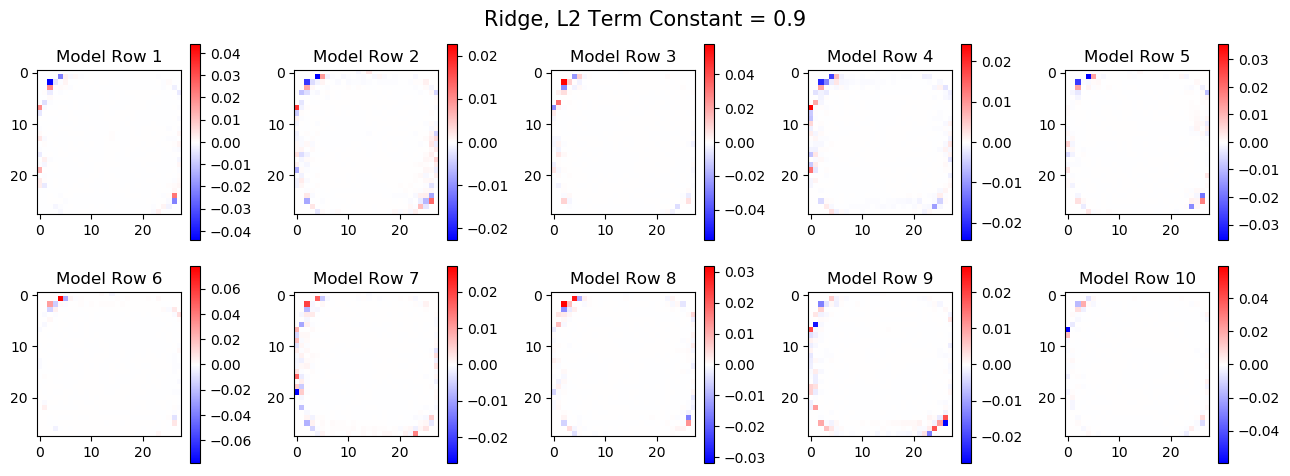

In [7]:
# Method 4: Ridge (linear least squares with L2 regularization)
alpha_vals = [0.1, 0.5, 0.9]
for alpha in alpha_vals:
    A = lm.Ridge(alpha=alpha).fit(X_train.T, Y_train.T).coef_
    plot_A(A, 'Ridge, L2 Term Constant = {}'.format(alpha))

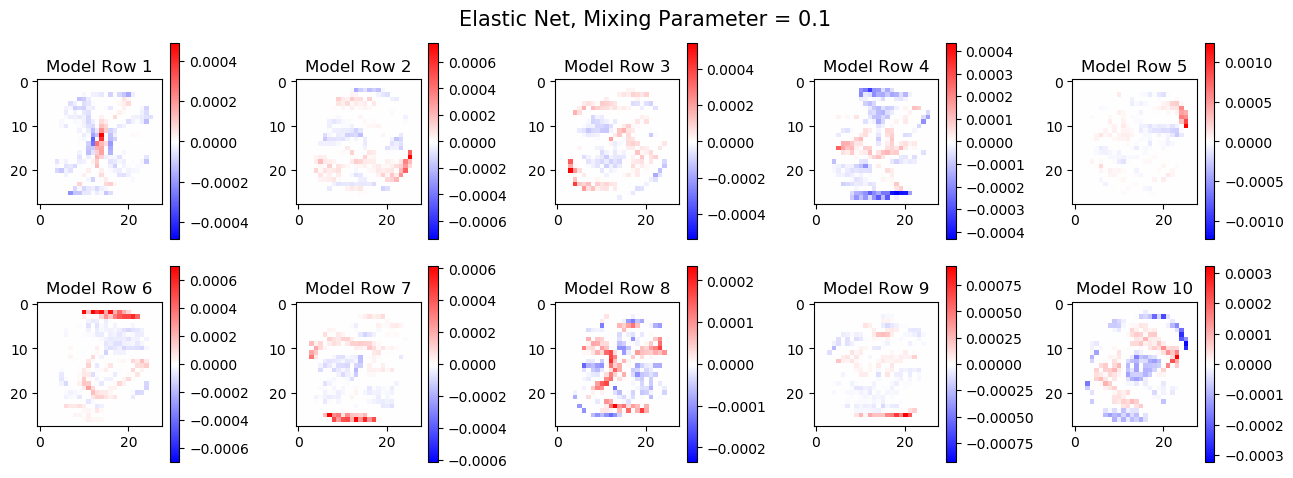

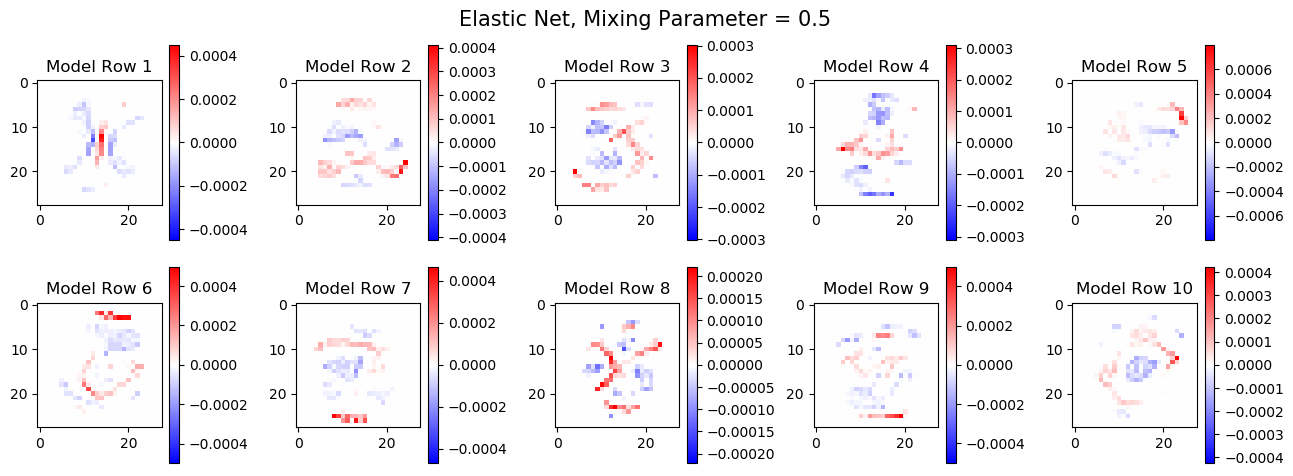

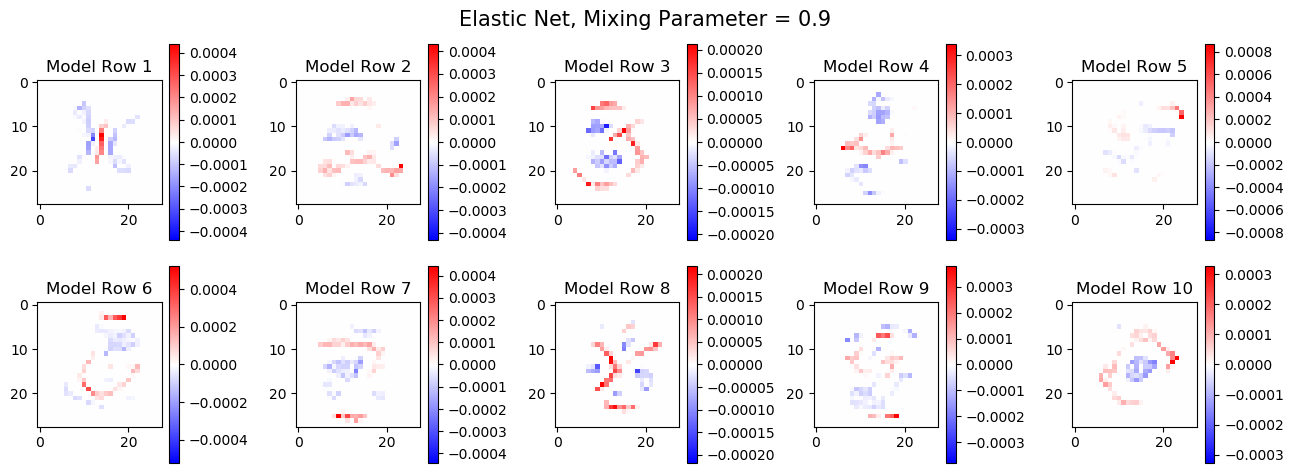

In [8]:
# Method 5: Elastic net (linear regression with combined L1 and L2 priors as regularizer)
ratios = [0.1, 0.5, 0.9] # L2 = 0, L1 = 1
for ratio in ratios:
    A = lm.ElasticNet(l1_ratio=ratio).fit(X_train.T, Y_train.T).coef_
    plot_A(A, 'Elastic Net, Mixing Parameter = {}'.format(ratio))

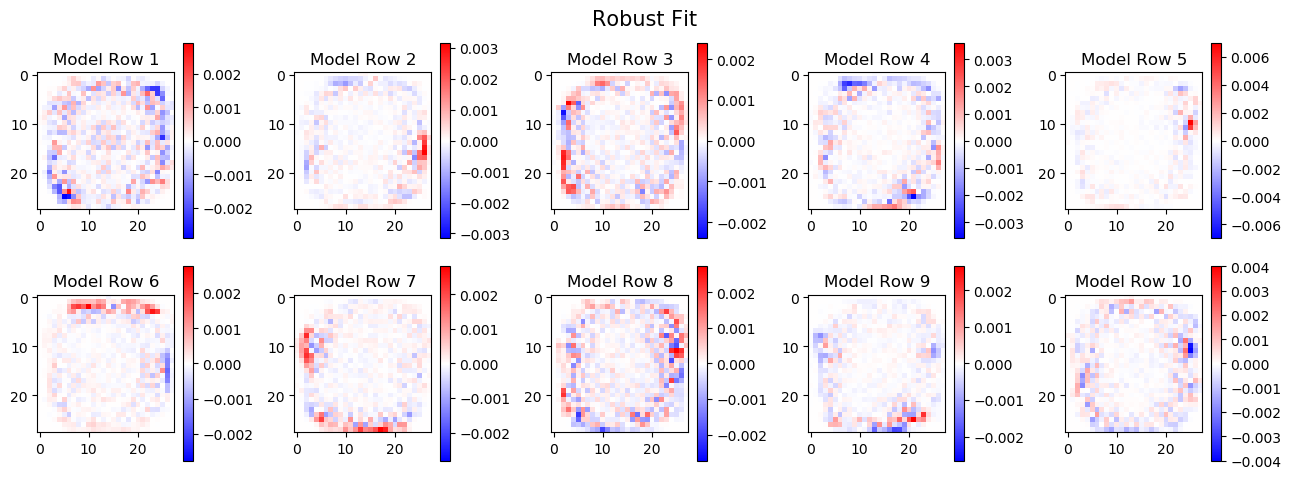

In [9]:
# Method 6: Robust fit (linear regression model that is robust to outliers)
A = np.empty((num_digits, N))
hr = lm.HuberRegressor()
for i in range(num_digits):
    A[i, :] = hr.fit(X_train.T, Y_train[i, :]).coef_
plot_A(A, 'Robust Fit')

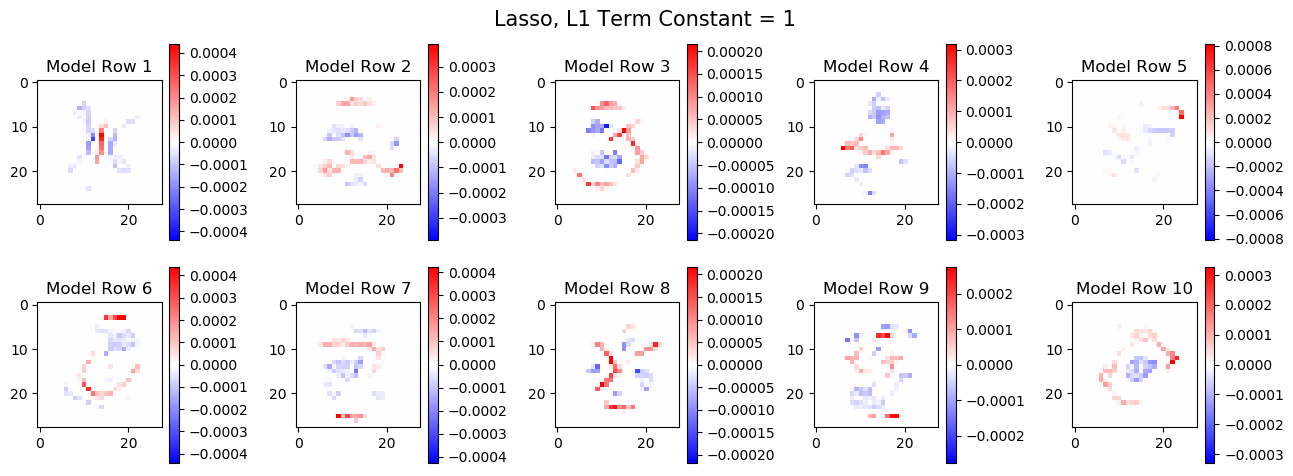

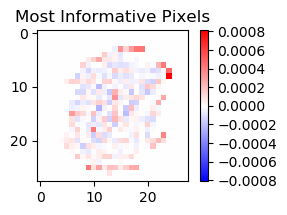

In [19]:
'''
2) By promoting sparsity, determine and rank which pixels in the MNIST set are 
   most informative for correctly labeling the digits.
'''
# Perform regression and regularize with the L1 norm 
alpha = 1
A = lm.Lasso(alpha=alpha).fit(X_train.T, Y_train.T).coef_
plot_A(A, 'Lasso, L1 Term Constant = {}'.format(alpha))

# Visualize the sum of all of the rows of the model in 2-D pixel space 
A_sum = np.sum(A, axis=0)
vmax = np.max(np.absolute(A_sum))
plt.figure(figsize=(3, 2), dpi=100)
plt.title('Most Informative Pixels')
plt.imshow(A_sum.reshape(rows, cols), cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

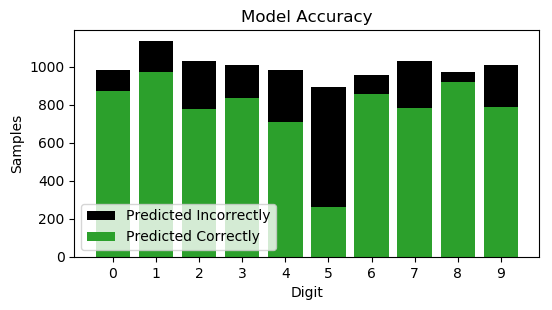

Model Accuracy Digit 0: 0.8887755102040816
Model Accuracy Digit 1: 0.8563876651982378
Model Accuracy Digit 2: 0.7538759689922481
Model Accuracy Digit 3: 0.8287128712871287
Model Accuracy Digit 4: 0.7209775967413442
Model Accuracy Digit 5: 0.29035874439461884
Model Accuracy Digit 6: 0.8914405010438413
Model Accuracy Digit 7: 0.7607003891050583
Model Accuracy Digit 8: 0.9455852156057495
Model Accuracy Digit 9: 0.7809712586719524


In [22]:
'''
3) Apply your most important pixels to the test data set to see how accurate you are 
   with as few pixels as possible.
'''
# Use model to get label estimates for the test images 
Y_pred = A @ X_test
Y_pred = estimate_labels(Y_pred)

# Count the number of times each digit appears in the test set, and of these,
# count the number of times the digit is correctly identified by the model
true_count = np.zeros(num_digits)
pred_count = np.zeros(num_digits)

for i in range(num_test):
    # Get the true label and the predicted label 
    true_label = Y_test[:, i]
    pred_label = Y_pred[:, i]
    
    # Get the indices associated with the labels
    true_index = np.argmax(true_label)
    pred_index = np.argmax(pred_label)
    
    # Record the occurence of the digit 
    true_count[true_index] += 1
    
    # Record if the digit was correctly identified 
    if (true_index == pred_index):
        pred_count[true_index] += 1
        
# Send digit 0 to the front 
true_count = np.roll(true_count, 1)
pred_count = np.roll(pred_count, 1)

# Plot model accuracy results 
plt.figure(figsize=(6, 3), dpi=100)
plt.title('Model Accuracy')
plt.bar(np.arange(num_digits), true_count, color='k', 
        label='Predicted Incorrectly')
plt.bar(np.arange(num_digits), pred_count, color='tab:green', 
        label='Predicted Correctly')
plt.xticks(np.arange(num_digits))
plt.xlabel('Digit')
plt.ylabel('Samples')
plt.legend(loc='lower left')
plt.show()

# Print model accuracy results
for digit in range(num_digits):
    acc = pred_count[digit] / true_count[digit]
    print('Model Accuracy Digit {}: {}'.format(digit, acc))

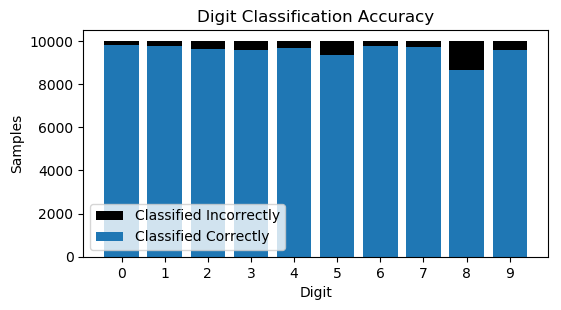

Classification Accuracy Digit 0: 0.9821
Classification Accuracy Digit 1: 0.9764
Classification Accuracy Digit 2: 0.9652
Classification Accuracy Digit 3: 0.9561
Classification Accuracy Digit 4: 0.9665
Classification Accuracy Digit 5: 0.9364
Classification Accuracy Digit 6: 0.976
Classification Accuracy Digit 7: 0.9711
Classification Accuracy Digit 8: 0.8658
Classification Accuracy Digit 9: 0.9584


In [23]:
# Compare the predicted labels with the true labels 
correct_count_all = np.zeros(num_digits)

for digit in range(num_digits):
    for i in range(num_test):
        # Get the true label and the predicted label 
        true_label = Y_test[digit - 1, i] 
        pred_label = Y_pred[digit - 1, i]

        # Record whether or not the digit was predicted correctly 
        if (true_label == pred_label):
            correct_count_all[digit] += 1

# Plot model accuracy results 
plt.figure(figsize=(6, 3), dpi=100)
plt.title('Digit Classification Accuracy')
plt.bar(np.arange(num_digits), np.ones(num_digits) * num_test, color='k', 
        label='Classified Incorrectly')
plt.bar(np.arange(num_digits), correct_count_all, color='tab:blue', 
        label='Classified Correctly')
plt.xticks(np.arange(num_digits))
plt.xlabel('Digit')
plt.ylabel('Samples')
plt.legend(loc='lower left')
plt.show()

# Print model accuracy results
for digit in range(num_digits):
    acc = correct_count_all[digit] / num_test
    print('Classification Accuracy Digit {}: {}'.format(digit, acc))

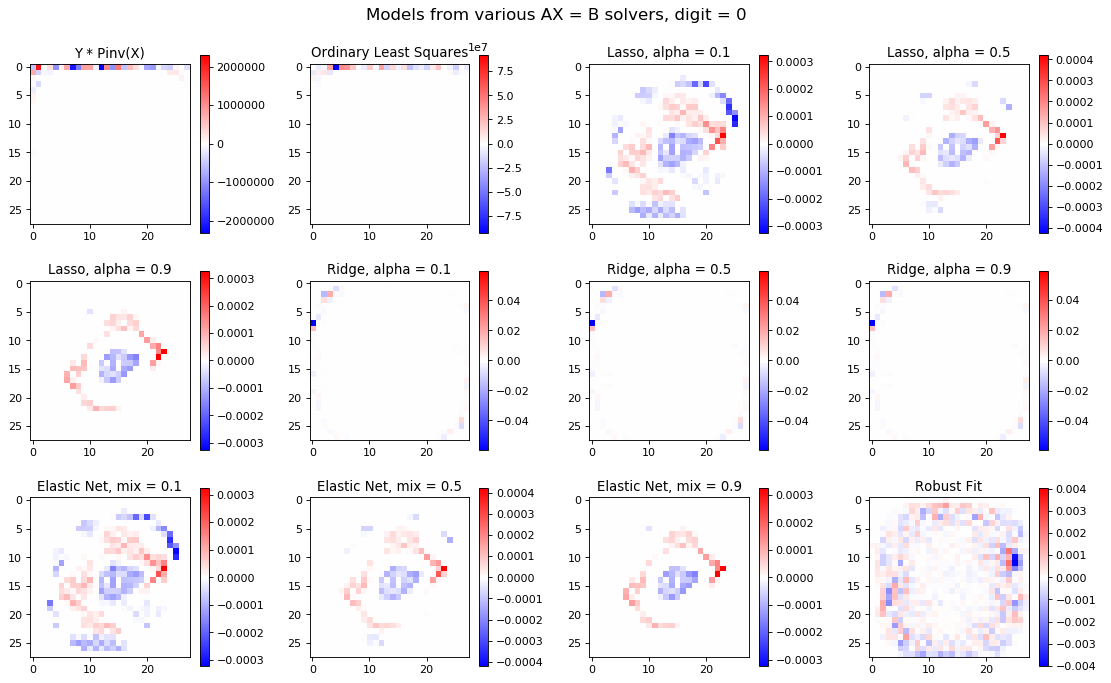

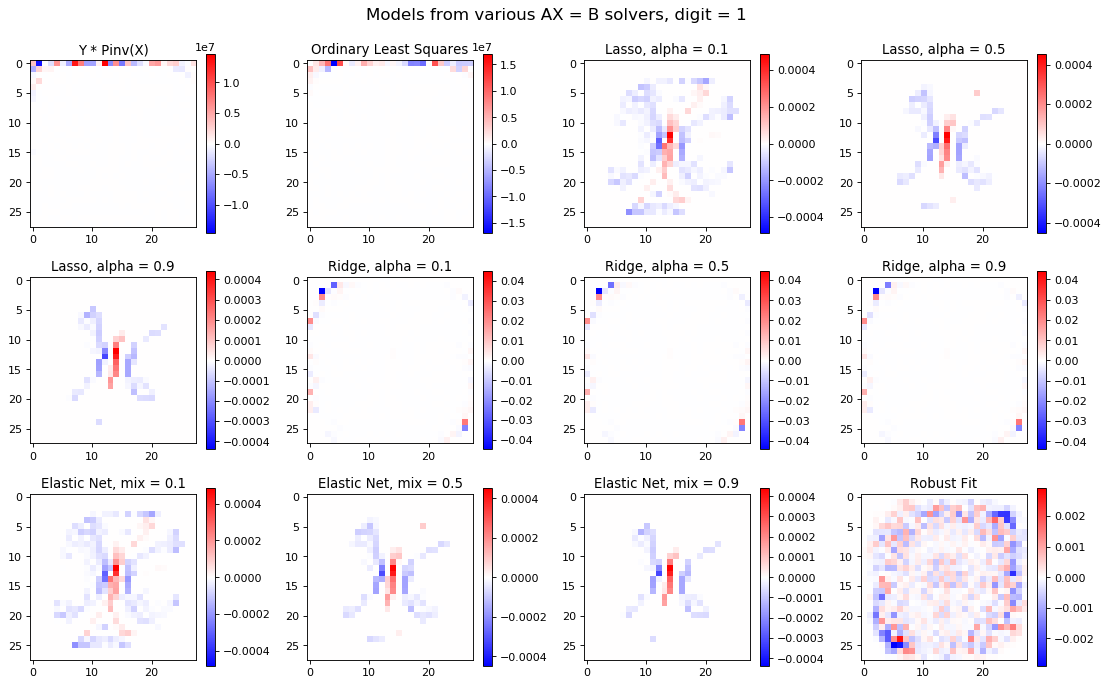

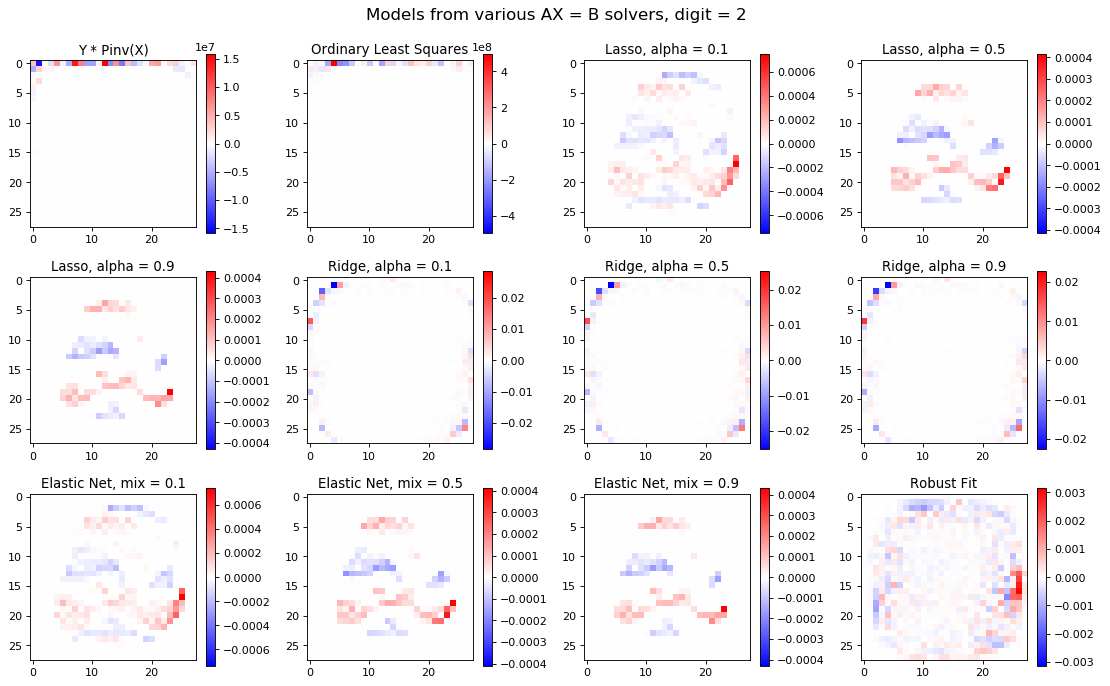

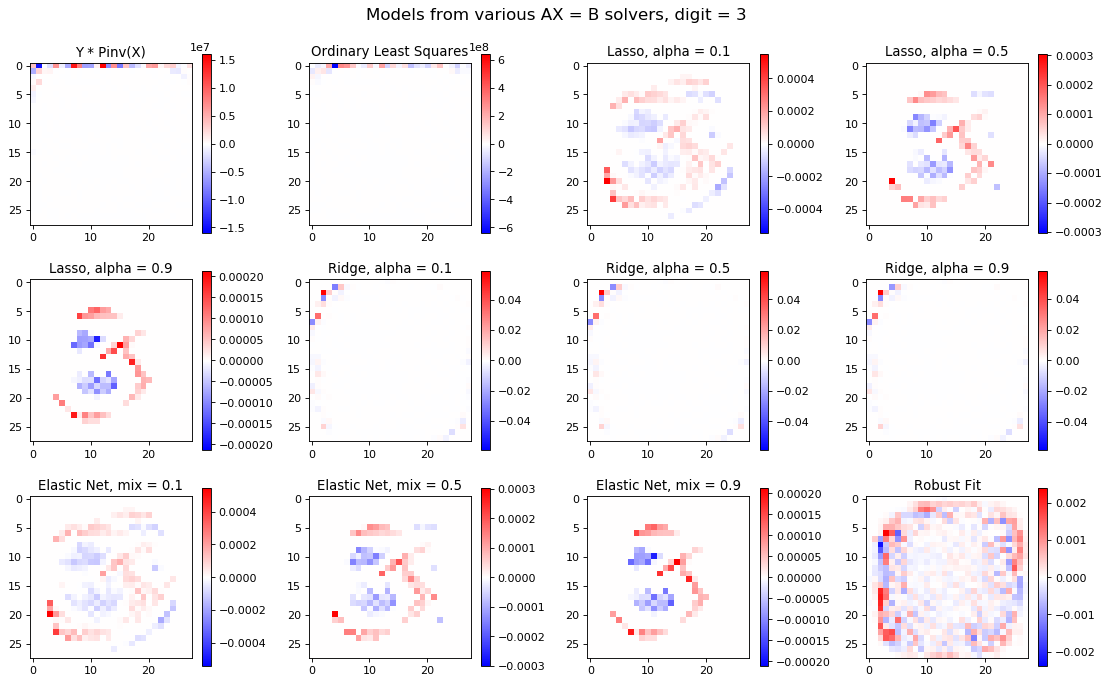

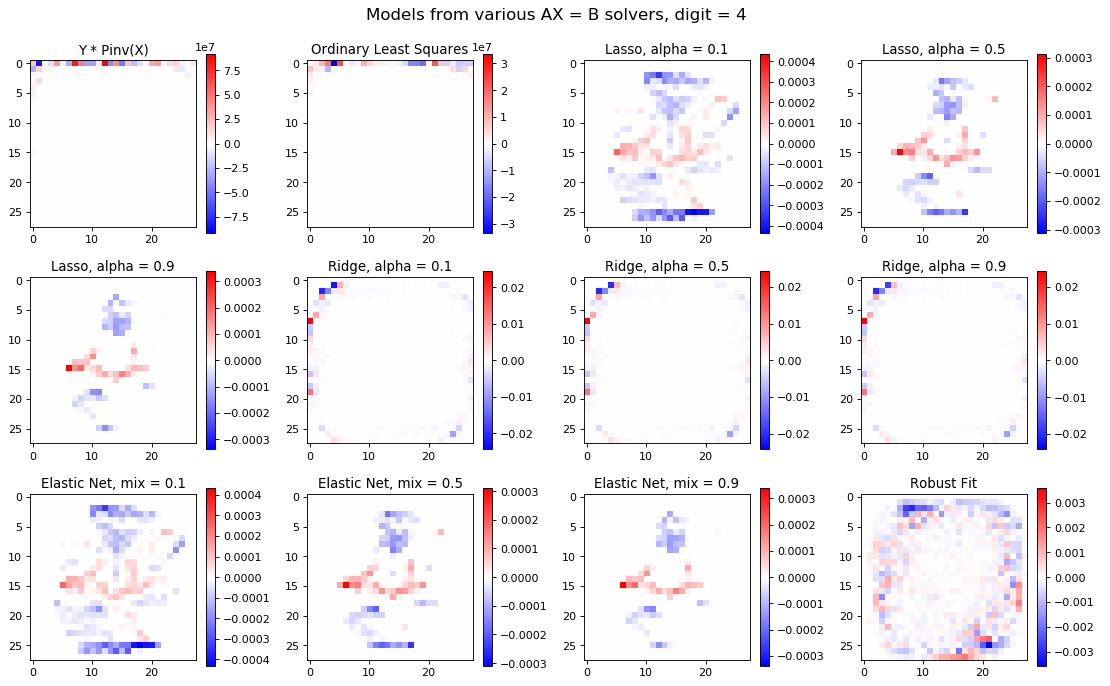

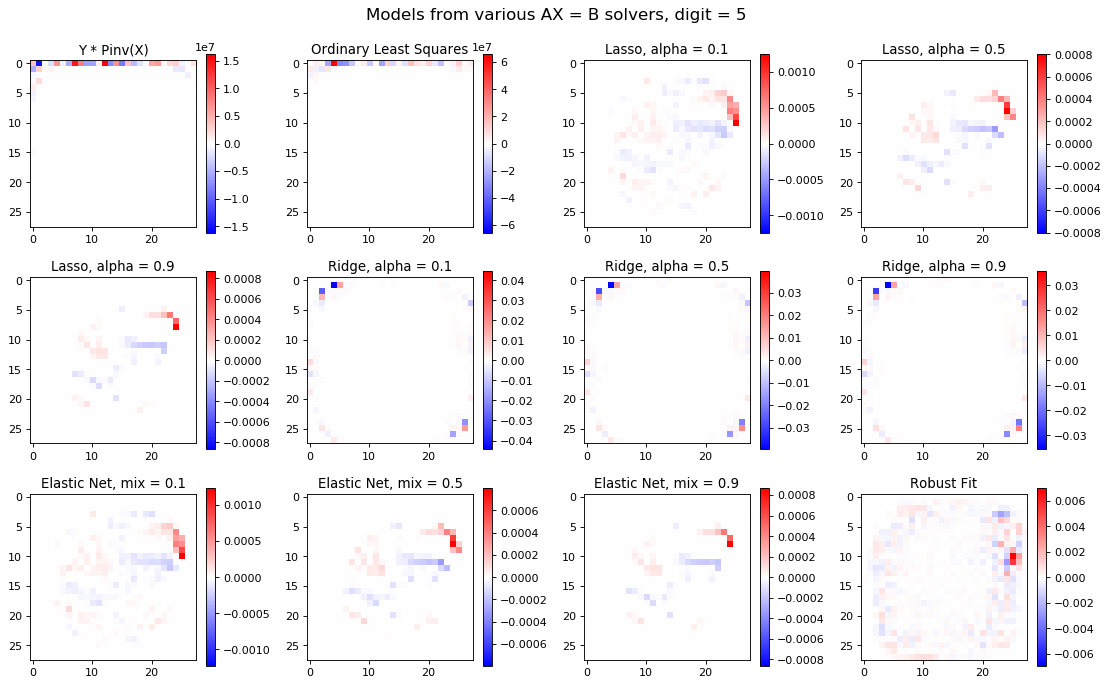

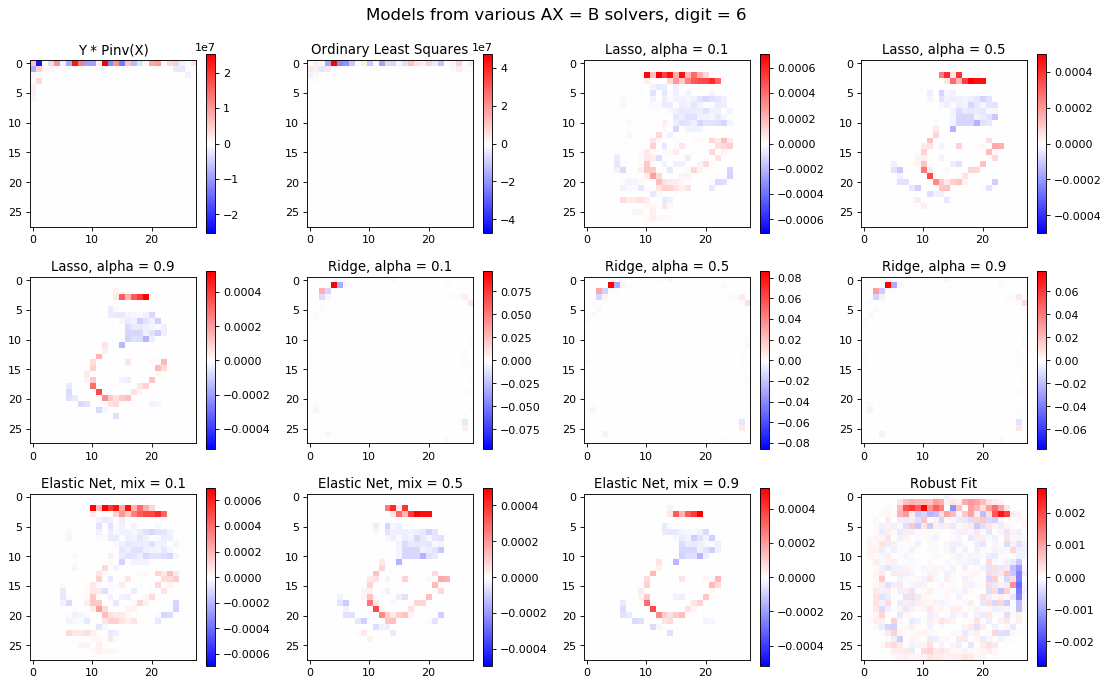

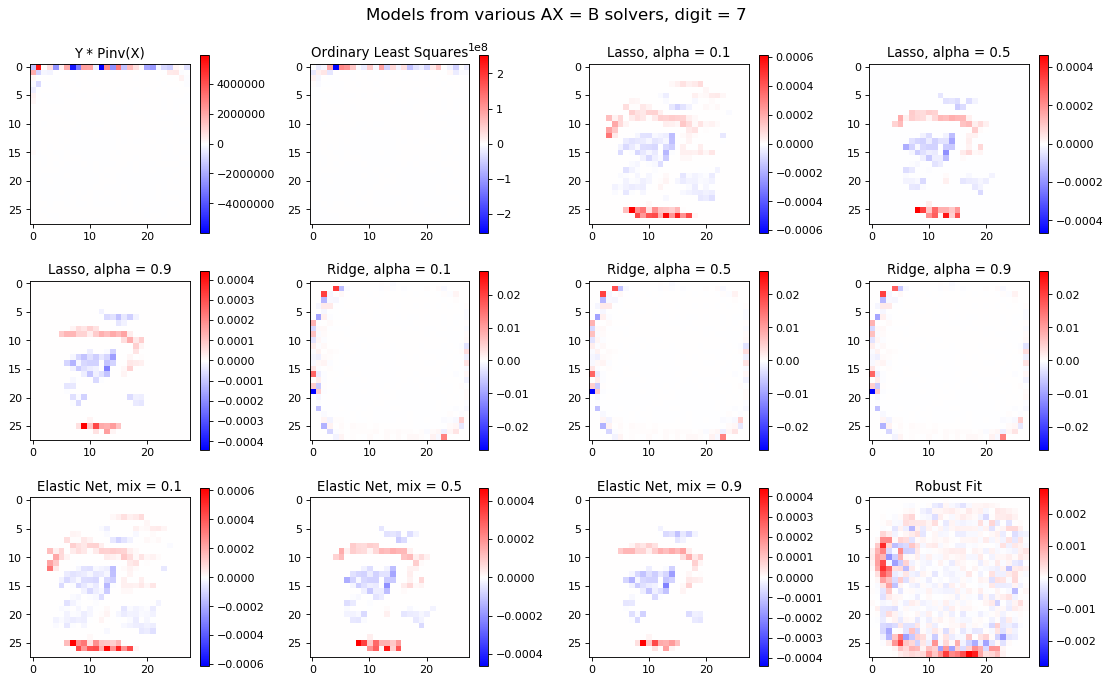

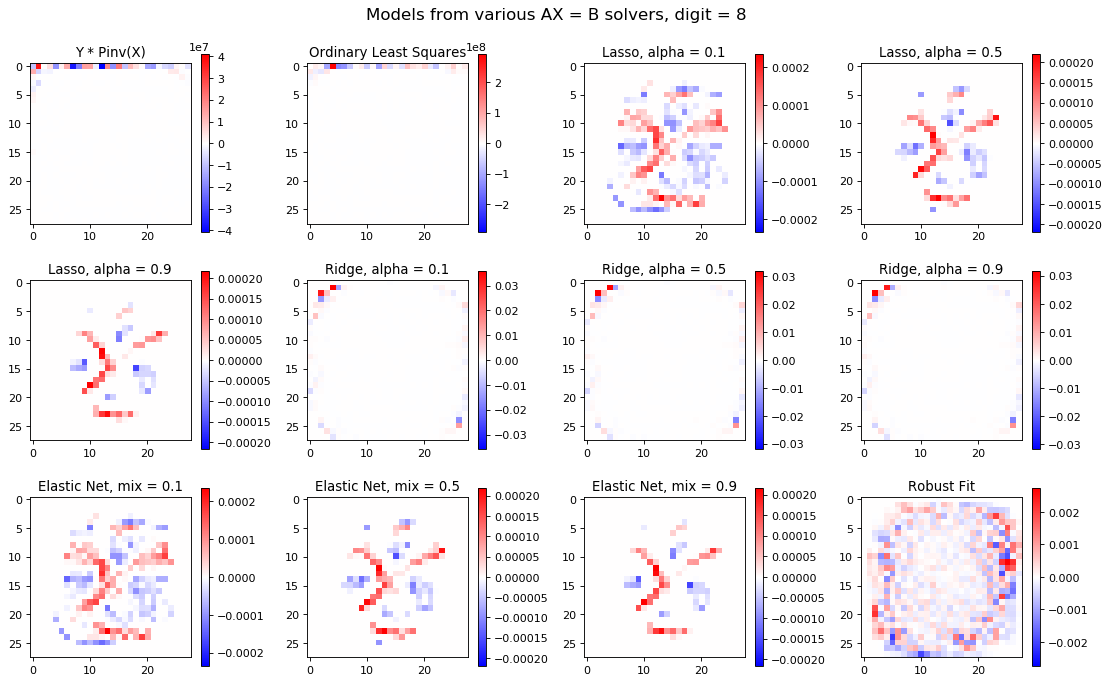

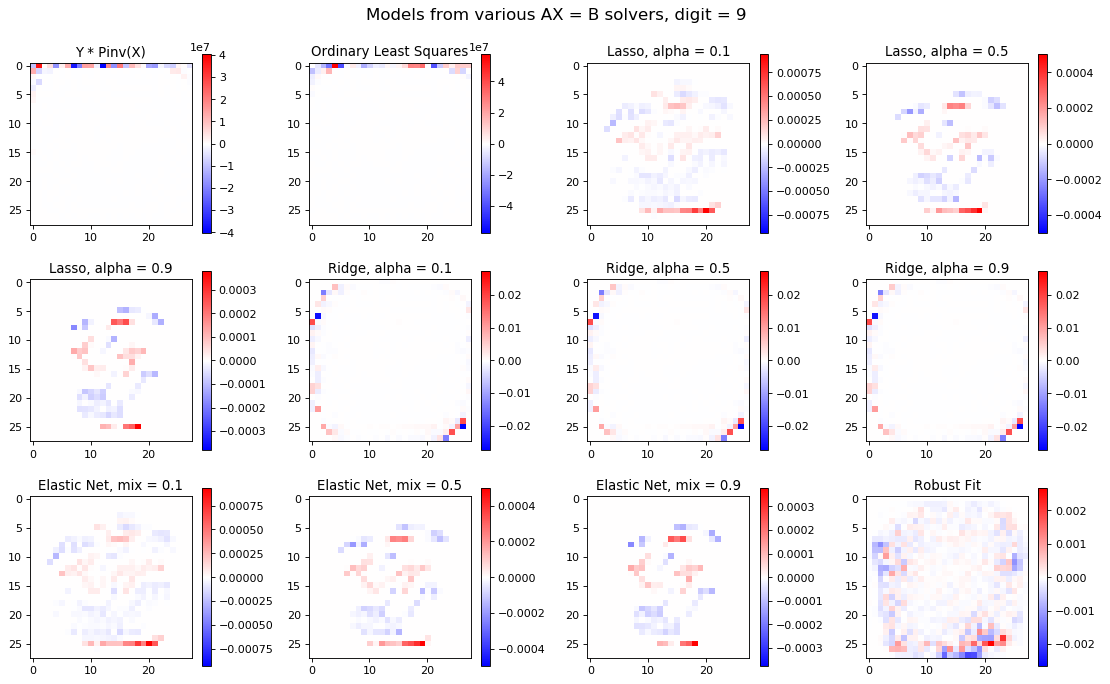

In [13]:
'''
4) Redo the analysis with each digit individually to find the most important 
   pixels for each digit.
'''
'''
4a) Using various AX = B solvers, determine a mapping from the image space 
    to the label space (but for each digit individually)
'''
for digit in range(num_digits):
    Y_train_dig = Y_train[digit - 1, :]

    plt.figure(figsize=(14, 9), dpi=80)
    plt.suptitle('Models from various AX = B solvers, digit = {}'.format(digit), fontsize=15)
    index = 1
    
    # Method 1: Pseudo inverse
    plt.subplot(3, 4, index)
    plt.title('Y * Pinv(X)')
    A = Y_train_dig @ linalg.pinv(X_train)
    vmax = np.max(np.absolute(A))
    plt.imshow(A.reshape(rows, cols), cmap='bwr', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    index += 1

    # Method 2: Ordinary least squares linear regression 
    plt.subplot(3, 4, index)
    plt.title('Ordinary Least Squares')
    A = lm.LinearRegression().fit(X_train.T, Y_train_dig).coef_
    vmax = np.max(np.absolute(A))
    plt.imshow(A.reshape(rows, cols), cmap='bwr', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    index += 1

    # Method 3: Lasso (linear model trained with L1 prior as regularizer)
    alpha_vals = [0.1, 0.5, 0.9]
    for alpha in alpha_vals:
        plt.subplot(3, 4, index)
        plt.title('Lasso, alpha = {}'.format(alpha))
        A = lm.Lasso(alpha=alpha).fit(X_train.T, Y_train_dig).coef_
        vmax = np.max(np.absolute(A))
        plt.imshow(A.reshape(rows, cols), cmap='bwr', vmin=-vmax, vmax=vmax)
        plt.colorbar()
        index += 1

    # Method 4: Ridge (linear least squares with l2 regularization)
    alpha_vals = [0.1, 0.5, 0.9]
    for alpha in alpha_vals:
        plt.subplot(3, 4, index)
        plt.title('Ridge, alpha = {}'.format(alpha))
        A = lm.Ridge(alpha=alpha).fit(X_train.T, Y_train_dig).coef_
        vmax = np.max(np.absolute(A))
        plt.imshow(A.reshape(rows, cols), cmap='bwr', vmin=-vmax, vmax=vmax)
        plt.colorbar()
        index += 1

    # Method 5: Elastic net (linear regression with combined L1 and L2 priors as regularizer)
    ratios = [0.1, 0.5, 0.9] 
    for ratio in ratios:
        plt.subplot(3, 4, index)
        plt.title('Elastic Net, mix = {}'.format(ratio))
        A = lm.ElasticNet(l1_ratio=ratio).fit(X_train.T, Y_train_dig).coef_
        vmax = np.max(np.absolute(A))
        plt.imshow(A.reshape(rows, cols), cmap='bwr', vmin=-vmax, vmax=vmax)
        plt.colorbar()
        index += 1

    # Method 6: Robust fit (linear regression model that is robust to outliers)
    plt.subplot(3, 4, index)
    plt.title('Robust Fit')
    A = lm.HuberRegressor().fit(X_train.T, Y_train_dig).coef_
    vmax = np.max(np.absolute(A))
    plt.imshow(A.reshape(rows, cols), cmap='bwr', vmin=-vmax, vmax=vmax)
    plt.colorbar()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

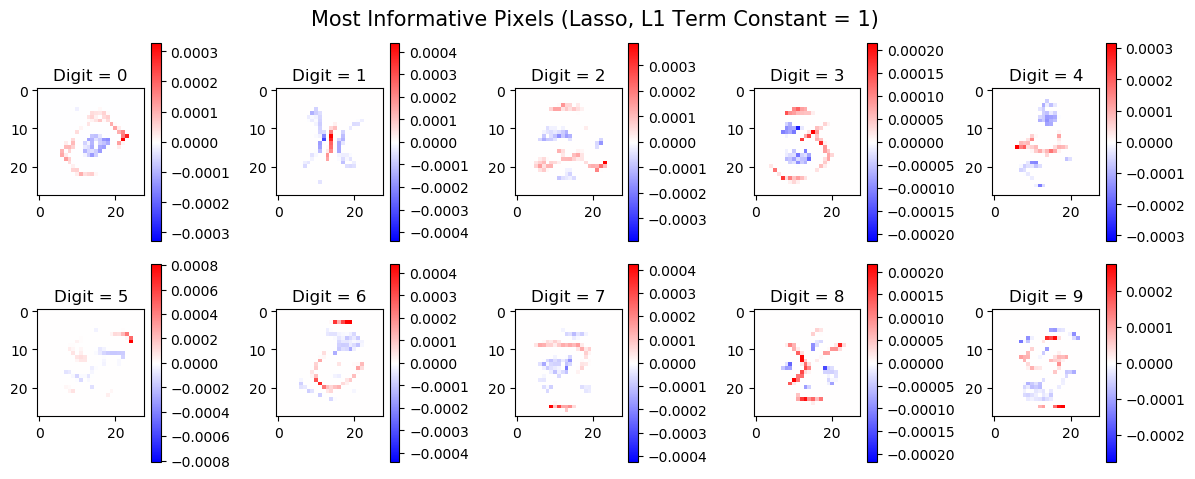

In [24]:
'''
4b) By promoting sparsity, determine and rank which pixels in the MNIST set are 
    most informative for correctly labeling the digits (but for each digit individually)
'''
# Save classifier for each digit 
all_A = np.empty((N, num_digits))

# Perform regression and regularize with the L1 norm 
alpha = 1

plt.figure(figsize=(12, 5), dpi=100)
plt.suptitle('Most Informative Pixels (Lasso, L1 Term Constant = {})'.format(alpha), 
             fontsize=15)

for digit in range(num_digits):
    # Compute the model 
    Y_train_dig = Y_train[digit - 1, :]
    A = lm.Lasso(alpha=alpha).fit(X_train.T, Y_train_dig).coef_
    
    # Save the model 
    all_A[:, digit] = A
    
    # Plot the model 
    vmax = np.max(np.absolute(A))
    plt.subplot(2, 5, digit + 1)
    plt.title('Digit = {}'.format(digit))
    plt.imshow(A.reshape(rows, cols), cmap='bwr', vmin=-vmax, vmax=vmax)
    plt.colorbar()
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

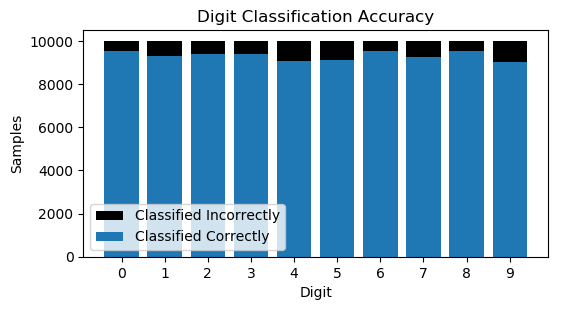

Classification Accuracy Digit 0: 0.9532
Classification Accuracy Digit 1: 0.932
Classification Accuracy Digit 2: 0.9377
Classification Accuracy Digit 3: 0.9396
Classification Accuracy Digit 4: 0.9076
Classification Accuracy Digit 5: 0.914
Classification Accuracy Digit 6: 0.9552
Classification Accuracy Digit 7: 0.9248
Classification Accuracy Digit 8: 0.9525
Classification Accuracy Digit 9: 0.9029


In [25]:
'''
4c) Apply your most important pixels to the test data set to see how accurate you are 
    with as few pixels as possible (but for each digit individually)
'''

# Compare the predicted labels with the true labels 
correct_count_sep = np.zeros(num_digits)

for digit in range(num_digits):
    # Get sparsity-promoting model 
    A = all_A[:, digit]

    # Get predictions for Y 
    Y_pred = A @ X_test
    Y_pred = estimate_labels(Y_pred)

    for i in range(num_test):
        # Get the true label and the predicted label 
        true_label = Y_test[digit - 1, i]
        pred_label = Y_pred[i]

        # Record whether or not the digit was predicted correctly 
        if (true_label == pred_label):
            correct_count_sep[digit] += 1

# Plot accuracy results 
plt.figure(figsize=(6, 3), dpi=100)
plt.title('Digit Classification Accuracy')
plt.bar(np.arange(num_digits), np.ones(num_digits) * num_test, color='k', 
        label='Classified Incorrectly')
plt.bar(np.arange(num_digits), correct_count_sep, color='tab:blue', 
        label='Classified Correctly')
plt.xticks(np.arange(num_digits))
plt.xlabel('Digit')
plt.ylabel('Samples')
plt.legend(loc='lower left')
plt.show()

# Print model accuracy results
for digit in range(num_digits):
    acc = correct_count_sep[digit] / num_test
    print('Classification Accuracy Digit {}: {}'.format(digit, acc))